# **Predicting patient no-shows and improving models with synthetic data**
---

## **The data**
Can we predict whether or not someone will show up to an appointment? There is a dataset from Brazil of patients and whether they show up to their hospital checkup appointments: (https://www.kaggle.com/joniarroba/noshowappointments).
The features for each patient are:

* ` PatientId `
* ` AppointmentID `
* ` Gender `
* ` ScheduledDay `
* ` AppointmentDay `
* ` Age `
* ` Neighbourhood `
* ` Scholarship `
* ` Hipertension `
* ` Diabetes `
* ` Alcoholism `
* ` Handcap `
* ` SMS_received `
* ` No-show `


# **The main problems**
When looking at patient dataset has about 100,000 patients, however it is skewed as around t 1/4 of the patients are no shows. Could more No-show patient data improve predictions? Lets see if generating synthetic data can improve predictions.

# **Libraries**

In [1]:
from pycaret.regression import * # Preprocessing, modelling, interpretation, deployment...
import pandas as pd # Basic data manipulation
import dabl as db # Summary plot
from sklearn.model_selection import train_test_split # Data split
from sdv.tabular import CopulaGAN # Synthetic data
from sdv.evaluation import evaluate # Evaluate synthetic data
from btb.tuning import Tunable, GCPTuner # CopulaGAN optimising
from btb.tuning import hyperparams as hp  # Set hyperparameters for optimising
import joblib # Saving preparation steps

# **Importing data**

In [2]:
# Read and output the top 5 rows
data = pd.read_csv('train.csv')
data.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,cat41,cat42,cat43,cat44,cat45,cat46,cat47,cat48,cat49,cat50,cat51,cat52,cat53,cat54,cat55,cat56,cat57,cat58,cat59,cat60,cat61,cat62,cat63,cat64,cat65,cat66,cat67,cat68,cat69,cat70,cat71,cat72,cat73,cat74,cat75,cat76,cat77,cat78,cat79,cat80,cat81,cat82,cat83,cat84,cat85,cat86,cat87,cat88,cat89,cat90,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,A,B,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,D,B,B,D,D,B,D,C,B,D,B,A,A,A,A,A,D,B,C,E,A,C,T,B,G,A,A,I,E,G,J,G,BU,BC,C,AS,S,A,O,LB,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,D,D,A,B,C,B,D,B,A,A,A,A,A,D,D,C,E,E,D,T,L,F,A,A,E,E,I,K,K,BI,CQ,A,AV,BM,A,O,DP,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,B,B,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,B,D,B,D,C,B,B,B,A,A,A,A,A,D,D,C,E,E,A,D,L,O,A,B,E,F,H,F,A,AB,DK,A,C,AF,A,I,GK,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,D,B,B,D,D,D,B,C,B,D,B,A,A,A,A,A,D,D,C,E,E,D,T,I,D,A,A,E,E,I,K,K,BI,CS,C,N,AE,A,O,DJ,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,B,A,B,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,D,B,D,B,D,B,B,C,B,B,C,A,A,A,B,H,D,B,D,E,E,A,P,F,J,A,A,D,E,K,G,B,H,C,C,Y,BM,A,K,CK,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB


In [50]:
# Split real data into training + test set
train, test, target_train, target_test = train_test_split(data.drop("loss", axis = 1), data["loss"], test_size = 0.4, random_state = 42)
train["loss"] = target_train
test["loss"] = target_test

Target looks like regression
Showing only top 10 of 116 categorical features


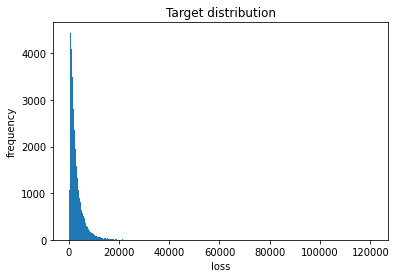

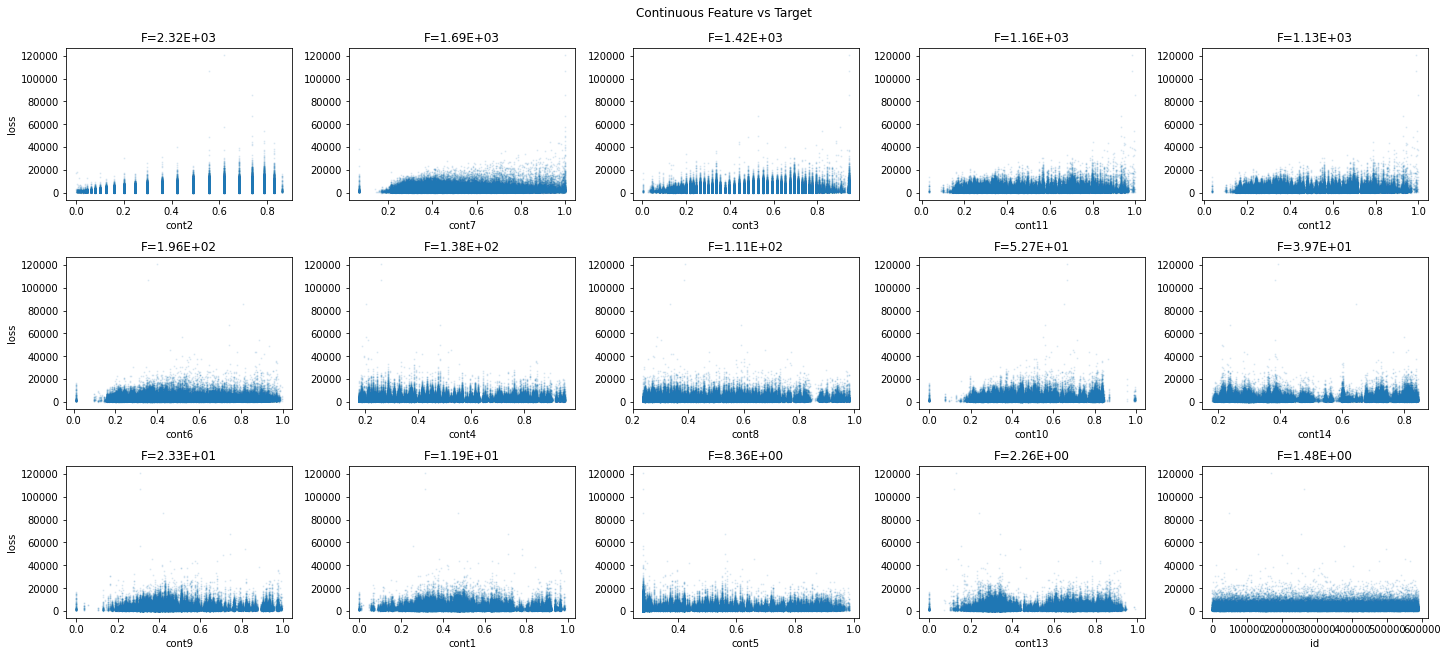

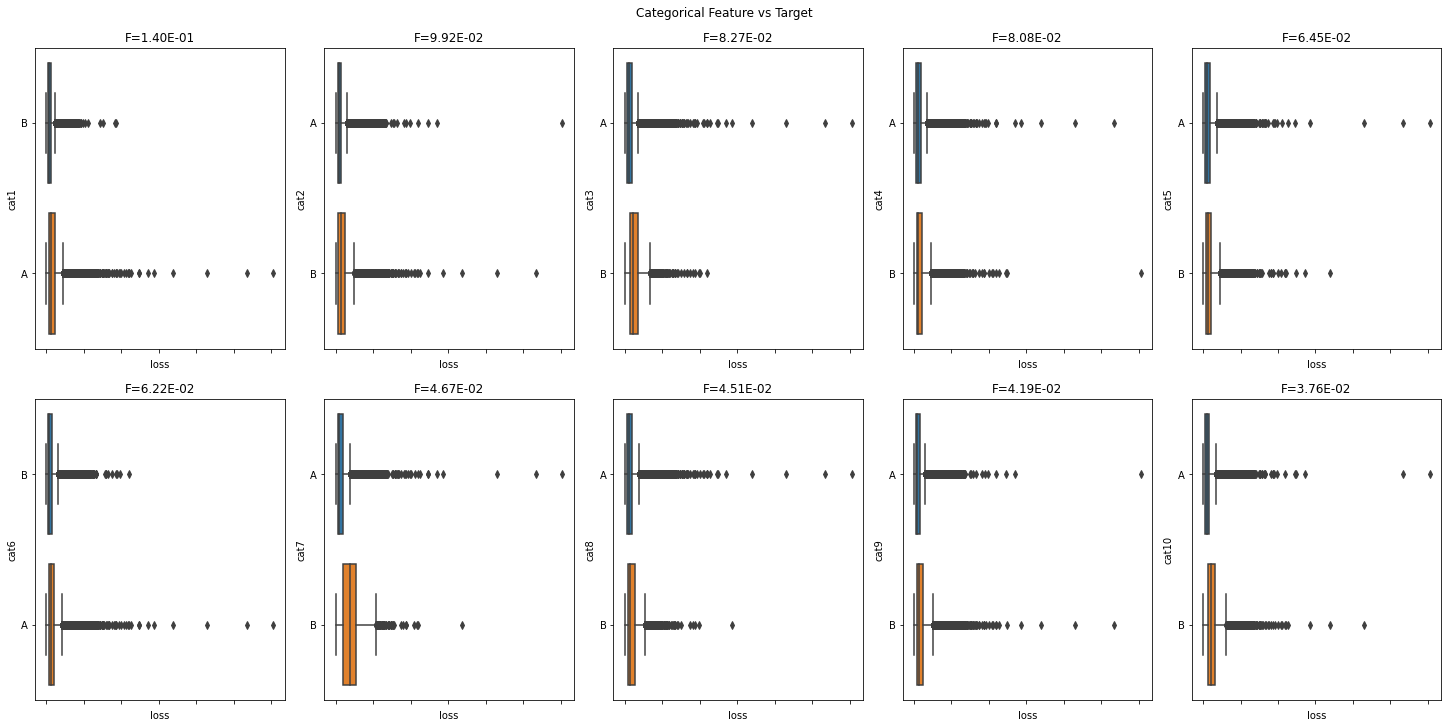

In [32]:
types = {each:'categorical' if "cat" in each else 'continuous' for each in train.columns}
del types['id']
db.plot(train, y = "loss", type_hints = types, plot_pairwise = False)

# **First modelling w/original data**
I'll use `Pycaret` to model the data given it's easy of use and speed. It can handle a lot of the preprocessing, modelling, evaluation and interpretation. Given the dataset is ~1.5k rows the processing isn't too intensive but if it increased in size thankfully Pycaret has GPU functionality.

Ordinal features need to have their levels known and ordered using a dictionary which can quickly be done.

True

A fairly simply ordering per feature. 


Now feature(s) can be initialised
* Target feature
* Continuous features
* Ordinal features
* Categorical features
* Features to ignore

In [51]:
# Target feature
target = "loss"

# Continuous/numeric features
cont_feats = [each for each in train.columns if "cont" in each ]
# Ordinal features
ord_feats = {}

# Categorical geatures
cat_feats = [each for each in train.columns if "cat" in each ]

# Features to ignore
ignore = ['id']#ignore id variables and datetime type columns

In [58]:
train.value_counts()[:1]

id      cat1  cat2  cat3  cat4  cat5  cat6  cat7  cat8  cat9  cat10  cat11  cat12  cat13  cat14  cat15  cat16  cat17  cat18  cat19  cat20  cat21  cat22  cat23  cat24  cat25  cat26  cat27  cat28  cat29  cat30  cat31  cat32  cat33  cat34  cat35  cat36  cat37  cat38  cat39  cat40  cat41  cat42  cat43  cat44  cat45  cat46  cat47  cat48  cat49  cat50  cat51  cat52  cat53  cat54  cat55  cat56  cat57  cat58  cat59  cat60  cat61  cat62  cat63  cat64  cat65  cat66  cat67  cat68  cat69  cat70  cat71  cat72  cat73  cat74  cat75  cat76  cat77  cat78  cat79  cat80  cat81  cat82  cat83  cat84  cat85  cat86  cat87  cat88  cat89  cat90  cat91  cat92  cat93  cat94  cat95  cat96  cat97  cat98  cat99  cat100  cat101  cat102  cat103  cat104  cat105  cat106  cat107  cat108  cat109  cat110  cat111  cat112  cat113  cat114  cat115  cat116  cont1     cont2     cont3     cont4     cont5     cont6     cont7     cont8    cont9    cont10   cont11    cont12    cont13    cont14   loss   
587633  B     A     A     B 

Now with the features initalised they can be fed into pycaret's `setup` function involving steps...
* Feed in data + features
* Normalize continuous features + use `minimax` as the normalization method
* Use stratified k folding on the data
* Remove features with low variance
* Split the data into 70:30 train:test

There a lot on offer but not everything is used here.

In [63]:
# Run pycaret setup
setup(train, 
      target = target,
     ignore_features = ignore)
print("setup complete!")

,Description,Value
0,session_id,4216
1,Target,loss
2,Original Data,"(112990, 132)"
3,Missing Values,False
4,Numeric Features,15
5,Categorical Features,116
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(79092, 955)"


setup complete!


Now it's "setup", I like to use `compare_models` to get a rough idea as to which model(s) might be best for this particular use case. The particular metrics I'm looking at are `AUC`, `Precision` and `Recall`. `Recall` is most important as we want to make sure we are correctly identifying the **true negatives** i.e. those that might leave in 6 months. Cross validation is also used.

In [ ]:
compare_models(sort = "RMSE")

IntProgress(value=0, description='Processing: ', max=99)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:24:23
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,AdaBoost Regressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,1265.0341,4046362.2297,2008.9643,0.5277,0.5959,0.6413,166.5940
ridge,Ridge Regression,1311.1510,4289142.1000,2069.5090,0.4990,0.6871,0.6627,0.6860
br,Bayesian Ridge,1311.3155,4304839.9410,2073.1189,0.4973,0.6870,0.6629,17.3410
lasso,Lasso Regression,1312.1813,4311799.5250,2073.8742,0.4972,0.6801,0.6663,12.1830
lr,Linear Regression,1324.1604,4344192.9000,2081.9966,0.4932,0.6923,0.6725,2.9670
omp,Orthogonal Matching Pursuit,1319.8090,4410977.9726,2098.5575,0.4846,0.6802,0.6679,0.5500
llar,Lasso Least Angle Regression,1488.3276,5392739.8365,2319.6759,0.3709,0.7050,0.8538,0.7660
en,Elastic Net,1501.9351,5611294.9500,2366.3411,0.3454,0.7019,0.8572,1.2370
dt,Decision Tree Regressor,1750.9119,7725447.0104,2777.5418,0.0968,0.8041,0.8145,2.7770
knn,K Neighbors Regressor,2167.9688,10294507.3000,3206.8155,-0.2031,0.9412,1.2510,3.5890


Exception in thread Thread-9:
Traceback (most recent call last):
  File "/Users/nassim/opt/anaconda3/envs/dai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/nassim/opt/anaconda3/envs/dai/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py", line 567, in run
    self.flag_executor_shutting_down()
  File "/Users/nassim/opt/anaconda3/envs/dai/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py", line 756, in flag_executor_shutting_down
    self.kill_workers()
  File "/Users/nassim/opt/anaconda3/envs/dai/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py", line 766, in kill_workers
    recursive_terminate(p)
  File "/Users/nassim/opt/anaconda3/envs/dai/lib/python3.6/site-packages/joblib/externals/loky/backend/utils.py", line 28, in recursive_terminate
    _recursive_terminate_without_psutil(process)
  File "/Users/nassim/opt/anaconda3/envs/dai/lib/python3.6/site-packages/joblib/externals/loky/b

In [104]:
catboost = create_model("catboost") # Create the catboost classifier

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7993,0.7328,0.0772,0.5445,0.1352,0.0892,0.1460
1,0.7975,0.7366,0.0712,0.5134,0.1251,0.0795,0.1313
2,0.8008,0.7483,0.0786,0.5730,0.1383,0.0938,0.1556
3,0.8011,0.7508,0.0801,0.5775,0.1407,0.0959,0.1584
4,0.8016,0.7460,0.0786,0.5889,0.1387,0.0954,0.1601
5,0.8044,0.7539,0.0809,0.6527,0.1439,0.1037,0.1795
6,0.8009,0.7403,0.0720,0.5808,0.1281,0.0872,0.1509
7,0.7982,0.7365,0.0787,0.5222,0.1368,0.0883,0.1409
8,0.8020,0.7421,0.0787,0.5955,0.1390,0.0962,0.1620
9,0.8002,0.7472,0.0720,0.5673,0.1277,0.0859,0.1471


In [111]:
pred_holdout = predict_model(catboost)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8031,0.7464,0.0723,0.5600,0.1280,0.0862,0.1465


In [112]:
dt = create_model("dt") # Create the dt classifier

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7312,0.5806,0.3272,0.3349,0.3310,0.1628,0.1628
1,0.7272,0.5778,0.3242,0.3273,0.3258,0.1548,0.1548
2,0.7229,0.5747,0.3234,0.3201,0.3218,0.1476,0.1476
3,0.7295,0.5822,0.3338,0.3343,0.3341,0.1644,0.1644
4,0.7275,0.5768,0.3190,0.3260,0.3225,0.1520,0.1520
5,0.7192,0.5745,0.3279,0.3162,0.3219,0.1450,0.1450
6,0.7358,0.5874,0.3311,0.3439,0.3374,0.1724,0.1725
7,0.7287,0.5855,0.3445,0.3362,0.3403,0.1696,0.1696
8,0.7212,0.5746,0.3274,0.3186,0.3230,0.1474,0.1474
9,0.7246,0.5752,0.3234,0.3230,0.3232,0.1504,0.1504


In [113]:
pred_holdout = predict_model(dt)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.7338,0.5900,0.3489,0.3392,0.3440,0.1770,0.1771


# **Setting up data for round 2**
The real dataset can be split into 60:40 training/test. Once this has been split the synthetic data can be added to the training data. This in a way doesn't "waste" the real dataset in the training.

In [105]:
ord_feats = {}

If we use pycaret without shuffling the test data we see strange kfold validation stats.

In [183]:
setup(synth_train, 
      target = target, 
      test_data = test,
      fold_strategy = "stratifiedkfold",
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      ignore_features = ignore,
      normalize = True,
      normalize_method = "zscore",
      data_split_stratify = True,
      ignore_low_variance = True,
      silent = True, verbose = False)
print("setup complete!")

setup complete!


In [184]:
et = create_model("et") # Create the catboost classifier

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5685,0.7086,0.2292,0.7246,0.3483,0.1405,0.1928
1,0.5654,0.7122,0.2306,0.7090,0.3480,0.1342,0.1822
2,0.7445,0.8444,0.5967,0.8507,0.7014,0.4898,0.5134
3,0.9091,0.9788,0.9598,0.8724,0.9140,0.8182,0.8224
4,0.9131,0.9820,0.9648,0.8752,0.9178,0.8261,0.8305
5,0.9122,0.9787,0.9611,0.8764,0.9168,0.8244,0.8283
6,0.9127,0.9785,0.9635,0.8754,0.9174,0.8253,0.8296
7,0.9096,0.9791,0.9596,0.8732,0.9144,0.8191,0.8232
8,0.9097,0.9781,0.9583,0.8743,0.9143,0.8193,0.8231
9,0.9117,0.9789,0.9596,0.8765,0.9162,0.8232,0.8270


In [180]:
# Run pycaret setup w/synthetic data
# https://pycaret.readthedocs.io/en/latest/api/classification.html?highlight=setup#pycaret.classification.setup 
#test_data is the hold out set, we run 10 fol cross validation
setup(synth_train.sample(frac=1), 
      target = target, 
      test_data = test,
      fold_strategy = "stratifiedkfold",
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      ignore_features = ignore,
      normalize = True,
      normalize_method = "zscore",
      data_split_stratify = True,
      ignore_low_variance = True,
      silent = True, verbose = False)
print("setup complete!")

setup complete!


Now setup the `compare_models` can be checked again. Interestingly the `AUC`, `Recall` and `Precision` all went up considerably. `Recall` nearly doubled!

In [107]:
#Models sorted by f1 score
compare_models(sort = "F1")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8255,0.9117,0.7788,0.8414,0.7813,0.6516,0.6672,7.0960
rf,Random Forest Classifier,0.8373,0.9214,0.7666,0.8738,0.7808,0.6754,0.6935,4.6150
dt,Decision Tree Classifier,0.7976,0.7978,0.7872,0.7877,0.7700,0.5956,0.6081,0.4570
catboost,CatBoost Classifier,0.8419,0.9250,0.7475,0.8952,0.7683,0.6848,0.7038,16.0910
xgboost,Extreme Gradient Boosting,0.8409,0.9240,0.7443,0.8912,0.7653,0.6829,0.7005,7.7090
gbc,Gradient Boosting Classifier,0.8335,0.9190,0.7449,0.8746,0.7622,0.6681,0.6846,5.0530
ada,Ada Boost Classifier,0.8208,0.9106,0.7439,0.8524,0.7612,0.6426,0.6571,1.0880
lightgbm,Light Gradient Boosting Machine,0.8410,0.9239,0.7350,0.9017,0.7590,0.6831,0.7018,1.0200
knn,K Neighbors Classifier,0.8044,0.8816,0.7269,0.8425,0.7520,0.6096,0.6240,19.4760
svm,SVM - Linear Kernel,0.7537,0.0000,0.6970,0.7708,0.7200,0.5080,0.5139,0.2440


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=2002, verbose=0,
                     warm_start=False)

A CatBoost Classifier performed best:

In [181]:
#sorted by accuracy, each row corresponds to a cross validation
#https://pycaret.readthedocs.io/en/latest/api/classification.html?highlight=create_model#pycaret.classification.create_model
et = create_model("et") # Create the catboost classifier

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8362,0.9174,0.8001,0.8643,0.8310,0.6726,0.6745
1,0.8299,0.9141,0.7966,0.8552,0.8249,0.6598,0.6614
2,0.8337,0.9109,0.7924,0.8656,0.8274,0.6676,0.6700
3,0.8339,0.9138,0.7941,0.8646,0.8279,0.6679,0.6702
4,0.8296,0.9110,0.7885,0.8610,0.8232,0.6593,0.6617
5,0.8335,0.9148,0.7945,0.8636,0.8276,0.6672,0.6694
6,0.8353,0.9132,0.7941,0.8672,0.8291,0.6707,0.6732
7,0.8322,0.9101,0.7883,0.8660,0.8253,0.6645,0.6673
8,0.8414,0.9194,0.8104,0.8657,0.8371,0.6829,0.6843
9,0.8401,0.9126,0.7962,0.8747,0.8336,0.6803,0.6831


A gradient boosting classifier was decided upon.

In [182]:
pred_holdout = predict_model(et)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7634,0.7188,0.3134,0.3869,0.3463,0.2038,0.2054


In [117]:
synth_catboost = create_model("catboost")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5345,0.7280,0.1122,0.7491,0.1952,0.0738,0.1405
1,0.5356,0.7333,0.1133,0.7556,0.1971,0.0758,0.1443
2,0.7434,0.8596,0.5357,0.9212,0.6775,0.4881,0.5378
3,0.9424,0.9895,0.9568,0.9307,0.9436,0.8849,0.8852
4,0.9437,0.9907,0.9632,0.9276,0.9451,0.8873,0.8880
5,0.9470,0.9907,0.9619,0.9346,0.9480,0.8939,0.8943
6,0.9471,0.9904,0.9630,0.9340,0.9483,0.8942,0.8947
7,0.9408,0.9891,0.9583,0.9266,0.9422,0.8816,0.8822
8,0.9412,0.9889,0.9562,0.9290,0.9424,0.8824,0.8828
9,0.9441,0.9896,0.9577,0.9330,0.9452,0.8882,0.8885


In [121]:
pred_holdout = predict_model(synth_catboost)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.7892,0.7393,0.1798,0.4345,0.2544,0.1555,0.1761


In [128]:
pred = predict_model(synth_catboost, data=test)

,PatientId,AppointmentID,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handicap,...,Appointment_day_name,Register_year,Register_month,Register_day,Register_day_name,Register_hour,waiting_time,No-show,Label,Score
84674,2.759575e+13,5756417,F,20,ILHA DAS CAIEIRAS,0,0,0,0,0,...,Wednesday,2016,6,1,Wednesday,8,-1,No,No,0.9285
3635,9.673194e+14,5523159,F,37,RESISTÊNCIA,0,0,0,0,0,...,Tuesday,2016,3,29,Tuesday,16,34,No,Yes,0.6218
16605,3.951641e+12,5693080,F,38,MARIA ORTIZ,0,0,0,0,0,...,Friday,2016,5,12,Thursday,17,7,Yes,No,0.5410
103942,9.173245e+14,5654129,F,24,SANTO ANDRÉ,0,0,0,0,0,...,Friday,2016,5,3,Tuesday,13,30,Yes,No,0.5915
274,3.995366e+12,5641070,F,41,MARIA ORTIZ,0,0,0,0,0,...,Friday,2016,4,29,Friday,12,-1,No,No,0.9683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77440,5.134886e+13,5665127,F,10,BELA VISTA,0,0,0,0,0,...,Friday,2016,5,5,Thursday,13,7,No,No,0.6927
84883,5.821357e+13,5774289,F,4,CENTRO,0,0,0,0,0,...,Monday,2016,6,6,Monday,8,-1,No,No,0.9802
57918,1.681822e+13,5641394,F,29,CONQUISTA,1,0,0,0,0,...,Thursday,2016,4,29,Friday,13,12,No,No,0.6335
80372,5.649478e+08,5648719,M,58,MARUÍPE,0,0,0,0,0,...,Thursday,2016,5,2,Monday,16,2,No,No,0.7637


# **Conclusion**
Adding synthetic data seems to improve accuracy accross the board.